# <b>Introduction</b>

The goal for this notebook is to understand time series forecasting models such as ARIMA,  its parameters (p,d,q), as well as its variation SARIMA.

* AR(p): Auto-regression term => The lags of the previous value (from the pacf test)
*  I(d): Integral term        => For non-stationary differencing
* MA(q): Moving Average       => For the error term (from the acf test)

I am using the dataset ¨[Store Item Demand Forecasting](https://www.kaggle.com/c/demand-forecasting-kernels-onl)" from Kaggle Challenge.


Notebook Outline:

    ARIMA introduction
    Decompose the ts
    Stationarize the data
    Interpret ACF and PACF
    Determine p, d, q
    Adding seasonality: S-ARMIA
    Make some predictions



In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
#import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_style('darkgrid')
#darkgrid, whitegrid, dark, white, ticks}

In [6]:
matplotlib.rcParams['figure.figsize'] = [16, 4]
pd.set_option('display.max_columns', 100)

In [7]:
df = pd.read_csv('data/train.csv')

In [8]:
df_test = pd.read_csv('data/test.csv')

# <b>Exploratory Data Analysis</b>
 

In [9]:
df.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [11]:
df['date'] = pd.to_datetime(df.date)

In [12]:
df.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [14]:
print(df.store.unique())

[ 1  2  3  4  5  6  7  8  9 10]


In [15]:
print(df.item.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [16]:
print(df_test.store.unique())

[ 1  2  3  4  5  6  7  8  9 10]


In [17]:
print(df_test.item.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [18]:
#check for duplicates items
print(df.duplicated().sum())

0


In [19]:
#create new features based on the sales date
df['year']        = df['date'].dt.year
df['month']       = df['date'].dt.month
df['wk_num']      = df['date'].dt.week
df['wk_day_name'] = df['date'].dt.day_name()
df['wk_day_numb'] = df['date'].dt.weekday

In [20]:
df.head(15)

,date,store,item,sales,year,month,wk_num,wk_day_name,wk_day_numb
0,2013-01-01,1,1,13,2013,1,1,Tuesday,1
1,2013-01-02,1,1,11,2013,1,1,Wednesday,2
2,2013-01-03,1,1,14,2013,1,1,Thursday,3
3,2013-01-04,1,1,13,2013,1,1,Friday,4
4,2013-01-05,1,1,10,2013,1,1,Saturday,5
5,2013-01-06,1,1,12,2013,1,1,Sunday,6
6,2013-01-07,1,1,10,2013,1,2,Monday,0
7,2013-01-08,1,1,9,2013,1,2,Tuesday,1
8,2013-01-09,1,1,12,2013,1,2,Wednesday,2
9,2013-01-10,1,1,9,2013,1,2,Thursday,3


<Figure size 1152x288 with 0 Axes>

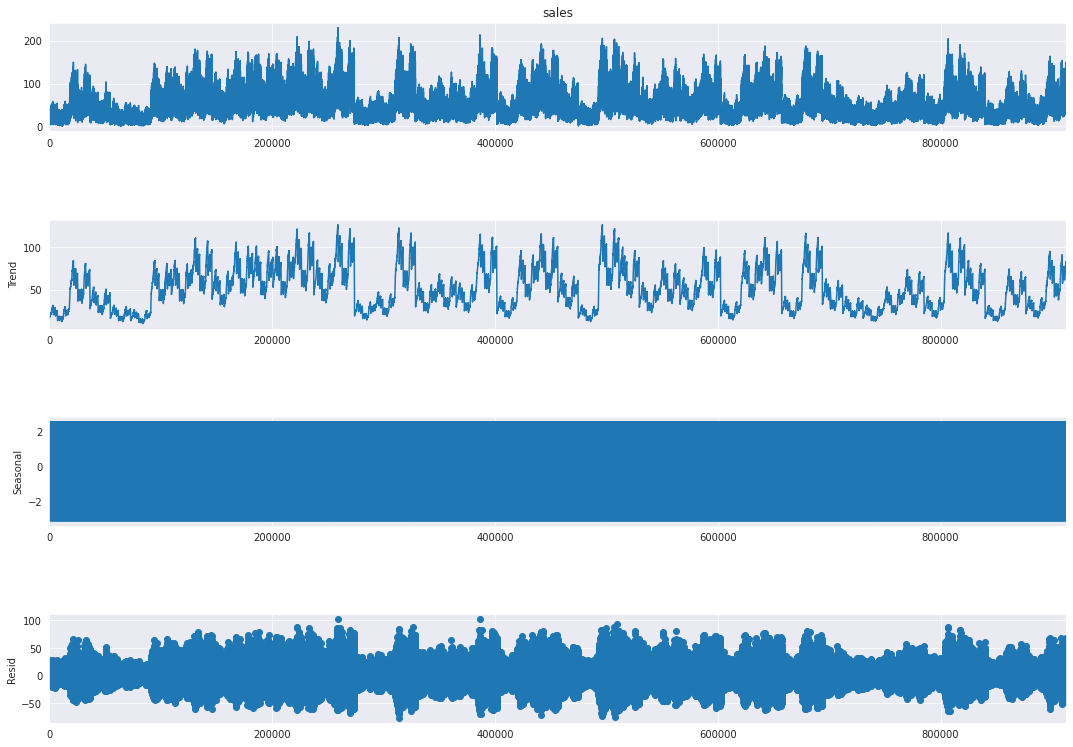

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['sales'], model='additive', period=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

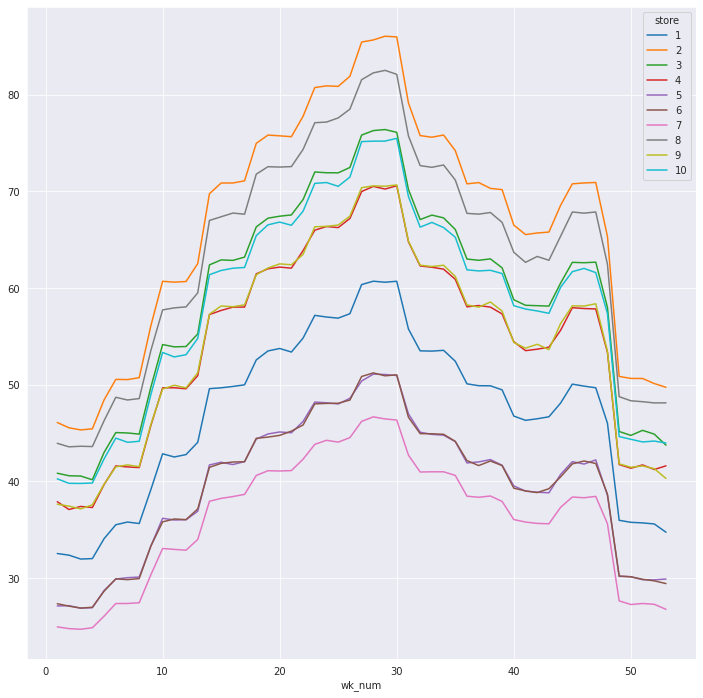

In [22]:
# sales per store by week_num
pivoted = pd.pivot_table(df, values='sales' , columns='store', index='wk_num')
pivoted.plot(figsize=(12,12));

In [23]:
pivoted.head(15)

store,1,2,3,4,5,6,7,8,9,10
wk_num,,,,,,,,,,
1,32.529412,46.087647,40.839412,37.894118,27.102353,27.335882,24.938824,43.934706,37.634706,40.258824
2,32.361143,45.540571,40.576000,37.082286,27.131429,27.084571,24.756571,43.569143,37.433714,39.793714
3,31.957143,45.320571,40.549143,37.401714,26.880000,26.881143,24.693714,43.629143,37.150286,39.782286
4,32.004000,45.433143,40.162857,37.292571,26.922286,26.970286,24.849714,43.598286,37.567429,39.825714
5,34.066857,48.430857,42.994286,39.662857,28.701714,28.629714,26.050857,46.272000,39.693143,42.321143
6,35.504571,50.547429,45.046857,41.593143,29.886857,29.908571,27.354286,48.698286,41.494286,44.473714
7,35.788000,50.529143,45.003429,41.492000,30.028000,29.826857,27.358857,48.417143,41.701143,44.040000
8,35.633714,50.726286,44.885714,41.422286,30.096000,29.936571,27.434857,48.565143,41.514857,44.144000
9,39.160000,56.122286,49.763429,45.786857,33.307429,33.314286,30.342286,53.560000,45.892571,49.004000


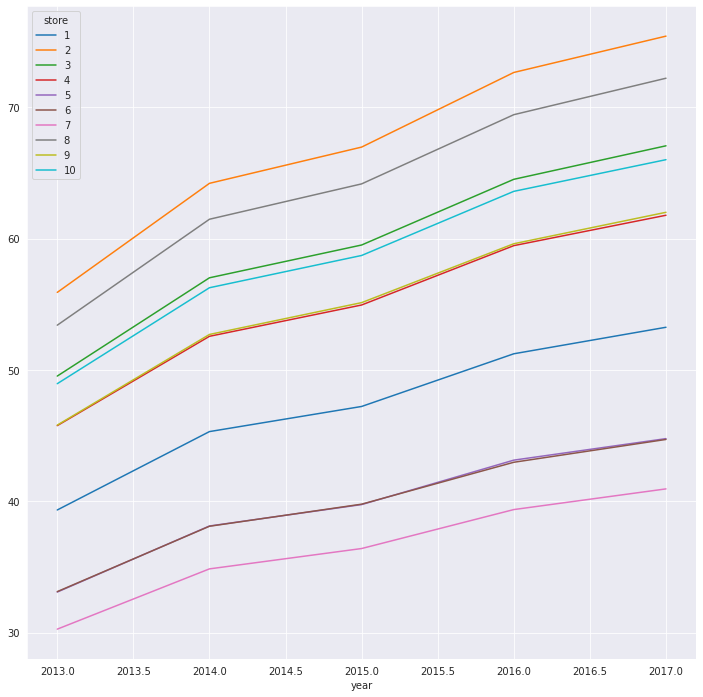

In [24]:
# sales per store by year
pivoted = pd.pivot_table(df, values='sales' , columns='store', index='year')
pivoted.plot(figsize=(12,12));

In [25]:
pivoted.head(15)

store,1,2,3,4,5,6,7,8,9,10
year,,,,,,,,,,
2013,39.333699,55.903452,49.530740,45.756658,33.084000,33.116329,30.258795,53.405753,45.796603,48.950575
2014,45.303342,64.208055,57.014795,52.559178,38.115014,38.093918,34.848110,61.473808,52.700219,56.257918
2015,47.216986,66.968986,59.512493,54.944110,39.744767,39.776274,36.398192,64.166904,55.124438,58.716000
2016,51.229126,72.651530,64.514699,59.464208,43.129563,42.967158,39.365137,69.436885,59.608251,63.598470
2017,53.247890,75.418411,67.066630,61.778082,44.768274,44.705041,40.940219,72.212384,62.003123,66.010082


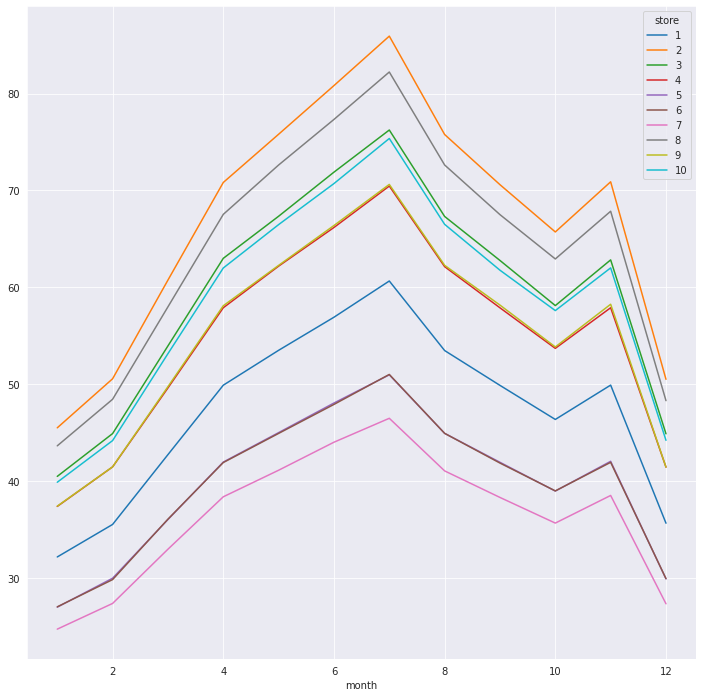

In [26]:
# sales per store by month
pivoted = pd.pivot_table(df, values='sales' , columns='store', index='month')
pivoted.plot(figsize=(12,12));

In [27]:
pivoted.head(15)

store,1,2,3,4,5,6,7,8,9,10
month,,,,,,,,,,
1,32.174452,45.503226,40.489935,37.389806,26.993290,27.025419,24.723097,43.644000,37.416129,39.885677
2,35.531064,50.566241,44.908794,41.470780,29.979858,29.837447,27.377163,48.450355,41.476454,44.185816
3,42.737290,60.753290,53.957677,49.619226,36.038968,36.075484,32.974194,57.991097,49.750452,53.158065
4,49.902400,70.826933,62.997067,57.894800,41.968267,41.918667,38.384133,67.534667,58.103067,61.998933
5,53.503613,75.804774,67.342065,62.190839,45.008387,44.926710,41.126323,72.630581,62.270581,66.478323
6,56.918800,80.828000,71.892933,66.181200,48.062267,47.918533,44.018133,77.334133,66.385867,70.714933
7,60.657935,85.932129,76.241548,70.457032,50.973290,51.013290,46.486452,82.228903,70.627355,75.368258
8,53.479097,75.778323,67.319613,62.138194,44.933161,44.932000,41.057032,72.632516,62.275097,66.507226
9,49.884533,70.598933,62.777733,57.889467,41.944933,41.864800,38.317200,67.507200,58.171733,61.771067


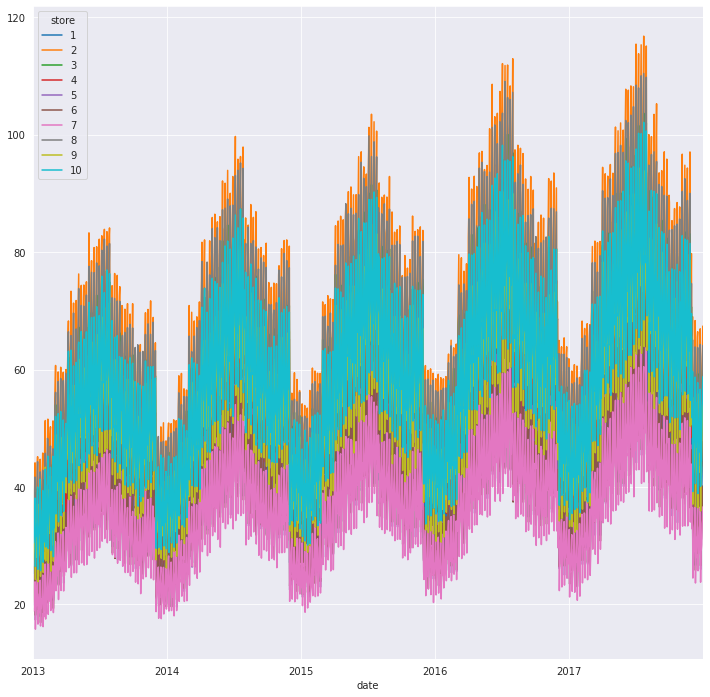

In [28]:
# sales per store by date
pivoted = pd.pivot_table(df, values='sales' , columns='store', index='date')
pivoted.plot(figsize=(12,12));

In [29]:
pivoted.head(15)

store,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,
2013-01-01,26.32,34.84,31.76,28.46,20.64,21.98,19.28,32.56,27.66,30.42
2013-01-02,25.28,36.16,30.76,28.64,19.94,20.46,18.88,33.74,29.10,30.60
2013-01-03,26.10,37.74,32.70,30.68,22.60,22.98,19.32,34.72,29.84,33.08
2013-01-04,29.04,39.66,34.82,33.70,25.16,24.02,20.80,39.32,32.24,34.78
2013-01-05,29.98,41.74,37.74,32.98,23.08,25.72,22.62,40.10,33.96,36.82
2013-01-06,32.26,44.12,39.12,38.54,25.30,27.18,23.86,41.70,35.62,38.12
2013-01-07,20.24,29.92,26.26,25.36,17.36,18.16,15.80,31.54,24.24,26.50
2013-01-08,24.56,36.00,30.76,28.62,19.84,20.04,18.64,33.30,28.88,30.56
2013-01-09,24.86,35.72,32.66,29.42,20.90,20.50,19.58,33.78,28.02,32.12



### <font color=blue>From the graphics we can conclude that stores 2 and 8 are the best ones in terms os sales amount and stores 5 and 7 are the worst ones</font>

In [30]:
# Sales distribution
sales_df = df.copy(deep=True)
sales_df['bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
total_sales = pd.value_counts(sales_df.bins).sum()
print('Sales per bins (%)')
display(pd.value_counts(sales_df.bins).apply(lambda r: '{:.2f}'.format((r/total_sales)*100)))

Sales per bins (%)


(0, 50]       54.59
(50, 100]     38.39
(100, 150]     6.71
(150, 200]     0.31
(200, 250]     0.00
Name: bins, dtype: object

In [31]:
# Let us understand the sales data distribution across the stores
store_df = df.copy()
sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
# Pivoted dataframe
display(sales_pivoted_df)


sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                                         \
item          7          8          9          10         11         12   
store                                                                     
1      52.783680  69.472070  46.504929  66.354326  63.217963  63.233844   
2      75.058598  99.090361  65.478094  94.097481  89.309967  89.350493   
3      66.647864  87.517525  58.486857  83.387733  79.291347  79.083790   
4      61.625411  80.819825  54.043812  77.047645  73.400876  73.102957   
5      44.535597  58.565717  38.837349  55.509858  52.980285  53.049288   
6      44.599124  58.385542  39.460022  55.565170  53.031763  52.872399   
7      40.709748  53.723987  35.901972  51.156627  48.393209  48.548740   
8      71.730559  94.461117  63.193319  89.818182  85.497262  85.644031   
9      61.812158  81.287514  54.105696  77.105148  73.168675  73.405257   
10     65.807777  86.176889  57.886637  82.232202  78.272180  78.058598   

                                                                            \
item           13         14          15         16         17          18   
store                                                                        
1       76.159365  53.148959   79.680723  23.332421  29.972070   76.345564   
2      107.903067  75.359803  112.578861  32.950164  42.568456  108.117196   
3       96.214677  66.841183  100.423330  29.142935  37.753012   96.090909   
4       88.604600  61.756846   92.653888  27.176889  34.552026   88.501643   
5       64.395947  44.912377   66.987404  19.389376  25.067360   64.080504   
6       64.324754  44.615553   66.668675  19.617196  25.058598   63.725630   
7       58.547645  41.022453   61.139102  17.754107  22.824754   58.745893   
8      103.819825  71.602957  108.047645  31.509858  40.290800  103.820372   
9       88.511501  61.458379   93.137459  26.997809  34.748631   88.610624   
10      94.684556  66.100219   98.990690  28.690033  37.112815   94.719606   

                                                                          \
item          19         20         21          22         23         24   
store                                                                      
1      36.676889  42.890471  36.176342   72.781490  26.469880  60.000000   
2      51.819825  60.978094  51.756298  103.009858  37.569003  84.782585   
3      45.854326  54.243702  45.955641   91.845564  33.389923  75.153888   
4      42.435926  50.022453  42.294633   84.634173  30.737130  69.119387   
5      30.704819  36.347755  30.491785   61.388280  22.348850  50.146769   
6      30.484118  36.196605  30.824206   61.030668  22.246440  50.508215   
7      28.180175  33.251369  28.210843   56.023549  20.243702  45.744797   
8      49.446878  58.046002  49.653341   98.914567  35.991785  81.207010   
9      42.587623  49.943045  42.575027   84.863089  30.881709  69.466046   
10     45.364732  53.239869  45.232749   90.531216  33.100219  74.317634   

                                                       

In [32]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [33]:
sales_across_store_df.head(25)

sales                                                         \
item           1          2          3          4          5          6   
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                                         \
item           7          8          9         10         11         12   
store                                                                     
1      52.783680  69.472070  46.504929  66.354326  63.217963  63.233844   
2      75.058598  99.090361  65.478094  94.097481  89.309967  89.350493   
3      66.647864  87.517525  58.486857  83.387733  79.291347  79.083790   
4      61.625411  80.819825  54.043812  77.047645  73.400876  73.102957   
5      44.535597  58.565717  38.837349  55.509858  52.980285  53.049288   
6      44.599124  58.385542  39.460022  55.565170  53.031763  52.872399   
7      40.709748  53.723987  35.901972  51.156627  48.393209  48.548740   
8      71.730559  94.461117  63.193319  89.818182  85.497262  85.644031   
9      61.812158  81.287514  54.105696  77.105148  73.168675  73.405257   
10     65.807777  86.176889  57.886637  82.232202  78.272180  78.058598   

                                                                            \
item           13         14          15         16         17          18   
store                                                                        
1       76.159365  53.148959   79.680723  23.332421  29.972070   76.345564   
2      107.903067  75.359803  112.578861  32.950164  42.568456  108.117196   
3       96.214677  66.841183  100.423330  29.142935  37.753012   96.090909   
4       88.604600  61.756846   92.653888  27.176889  34.552026   88.501643   
5       64.395947  44.912377   66.987404  19.389376  25.067360   64.080504   
6       64.324754  44.615553   66.668675  19.617196  25.058598   63.725630   
7       58.547645  41.022453   61.139102  17.754107  22.824754   58.745893   
8      103.819825  71.602957  108.047645  31.509858  40.290800  103.820372   
9       88.511501  61.458379   93.137459  26.997809  34.748631   88.610624   
10      94.684556  66.100219   98.990690  28.690033  37.112815   94.719606   

                                                                          \
item          19         20         21          22         23         24   
store                                                                      
1      36.676889  42.890471  36.176342   72.781490  26.469880  60.000000   
2      51.819825  60.978094  51.756298  103.009858  37.569003  84.782585   
3      45.854326  54.243702  45.955641   91.845564  33.389923  75.153888   
4      42.435926  50.022453  42.294633   84.634173  30.737130  69.119387   
5      30.704819  36.347755  30.491785   61.388280  22.348850  50.146769   
6      30.484118  36.196605  30.824206   61.030668  22.246440  50.508215   
7      28.180175  33.251369  28.210843   56.023549  20.243702  45.744797   
8      49.446878  58.046002  49.653341   98.914567  35.991785  81.207010   
9      42.587623  49.943045  42.575027   84.863089  30.881709  69.466046   
10     45.364732  53.239869  45.232749   90.531216  33.100219  74.317634   

                                                       

In [34]:
dfx = pd.DataFrame({
    'X': sales_across_store_df.index.values,
    'Y': sales_across_store_df.avg_sale.values,
    'Colors': sales_across_store_df.avg_sale.values,
    "bubble_size":sales_across_store_df.avg_sale.values * 15})

Text(0.5, 1.0, 'Bubble Plot of Avg Sales / Store')

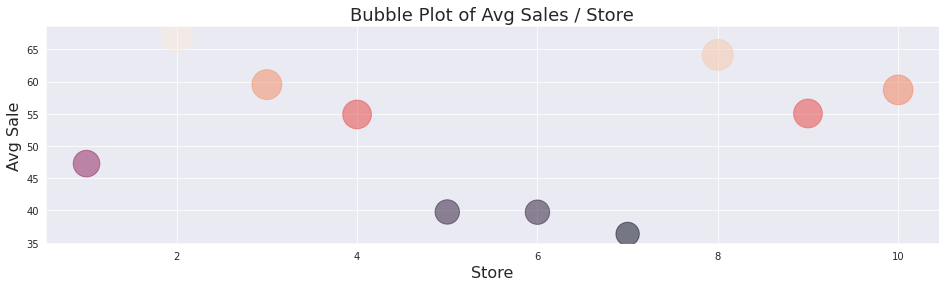

In [35]:
plt.scatter('X', 'Y',
             s='bubble_size',
             c='Colors',
             alpha=0.5, data=dfx)
plt.xlabel("Store", size=16)
plt.ylabel("Avg Sale", size=16)
plt.title("Bubble Plot of Avg Sales / Store", size=18)

In [36]:
#Create df per store 
df_store1 = df.loc[df['store'] == 1, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store2 = df.loc[df['store'] == 2, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store3 = df.loc[df['store'] == 3, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store4 = df.loc[df['store'] == 4, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store5 = df.loc[df['store'] == 5, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store6 = df.loc[df['store'] == 6, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store7 = df.loc[df['store'] == 7, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store8 = df.loc[df['store'] == 8, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store9 = df.loc[df['store'] == 9, : ].set_index('date').drop(['store'],axis=1).reset_index()
df_store10 = df.loc[df['store'] == 10, : ].set_index('date').drop(['store'],axis=1).reset_index()

In [37]:
df_store1.head()

,date,item,sales,year,month,wk_num,wk_day_name,wk_day_numb
0,2013-01-01,1,13,2013,1,1,Tuesday,1
1,2013-01-02,1,11,2013,1,1,Wednesday,2
2,2013-01-03,1,14,2013,1,1,Thursday,3
3,2013-01-04,1,13,2013,1,1,Friday,4
4,2013-01-05,1,10,2013,1,1,Saturday,5


In [38]:
df_store2.head()

,date,item,sales,year,month,wk_num,wk_day_name,wk_day_numb
0,2013-01-01,1,12,2013,1,1,Tuesday,1
1,2013-01-02,1,16,2013,1,1,Wednesday,2
2,2013-01-03,1,16,2013,1,1,Thursday,3
3,2013-01-04,1,20,2013,1,1,Friday,4
4,2013-01-05,1,16,2013,1,1,Saturday,5


In [39]:
# Artificial dataset for sure !
print(df_store1.shape)
print(df_store2.shape)
print(df_store3.shape)
print(df_store4.shape)
print(df_store5.shape)
print(df_store6.shape)
print(df_store7.shape)
print(df_store8.shape)
print(df_store9.shape)
print(df_store10.shape)
print(df.shape)

(91300, 8)
(91300, 8)
(91300, 8)
(91300, 8)
(91300, 8)
(91300, 8)
(91300, 8)
(91300, 8)
(91300, 8)
(91300, 8)
(913000, 9)


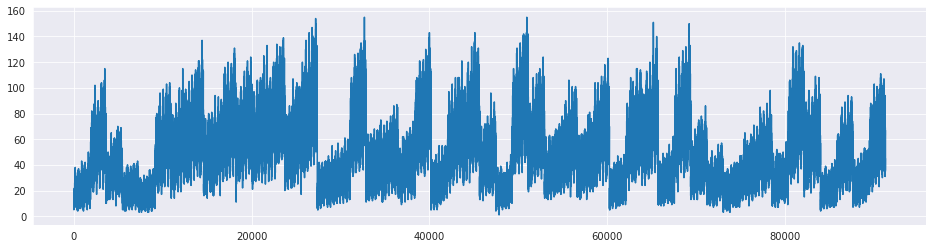

In [40]:
df_store1['sales'].plot(grid = True)

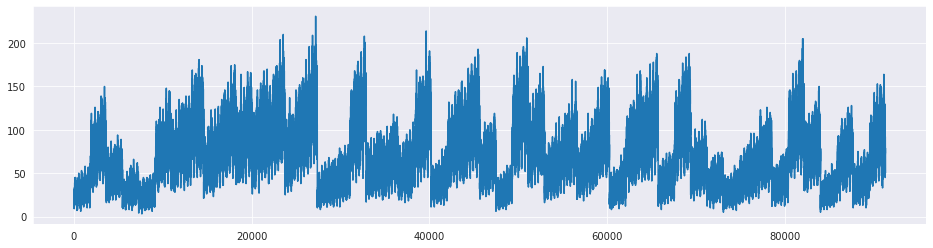

In [41]:
df_store2['sales'].plot(grid = True)

Sales Correlation between store 1 and store 2:  93.0 %


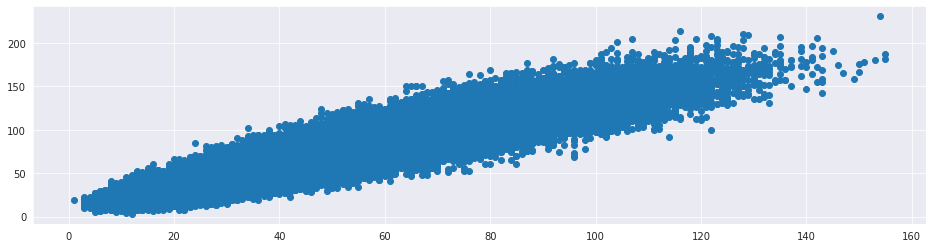

In [42]:
correlation = df_store1['sales'].corr(df_store2['sales'])
print("Sales Correlation between store 1 and store 2: ", np.round(correlation*100), "%" ) 
plt.scatter(df_store1['sales'], df_store2['sales'])
plt.show()

### <font color=blue>At this point I concluded that create 10 diferents models (one per store) to predict the sales is the be best solution because the stores have different sales averages, although, the same sales behavior.<br><font>
#### I will create, as example, just the model and the analysis for the store 1.

In [43]:
#df_store1 = df_store1.set_index('date')

In [44]:
df_store1.head(5)

,date,item,sales,year,month,wk_num,wk_day_name,wk_day_numb
0,2013-01-01,1,13,2013,1,1,Tuesday,1
1,2013-01-02,1,11,2013,1,1,Wednesday,2
2,2013-01-03,1,14,2013,1,1,Thursday,3
3,2013-01-04,1,13,2013,1,1,Friday,4
4,2013-01-05,1,10,2013,1,1,Saturday,5


In [45]:
df_store1.drop('wk_day_name', axis='columns', inplace=True)

In [46]:
df_store1['sales'] = df_store1['sales'].astype(float)
df_store1.head(5)

,date,item,sales,year,month,wk_num,wk_day_numb
0,2013-01-01,1,13.0,2013,1,1,1
1,2013-01-02,1,11.0,2013,1,1,2
2,2013-01-03,1,14.0,2013,1,1,3
3,2013-01-04,1,13.0,2013,1,1,4
4,2013-01-05,1,10.0,2013,1,1,5


### Time to analyze seasonality, trend and residual

In [47]:
#sns.lineplot(x="date", y="sales",legend = 'full' , data=df_store1)

In [48]:
#sns.lineplot(x="date", y="sales",legend = 'full' , data=df_store1[:28])

In [49]:
#sns.boxplot(x="wk_day_numb", y="sales", data=df_store1)

<Figure size 1152x288 with 0 Axes>

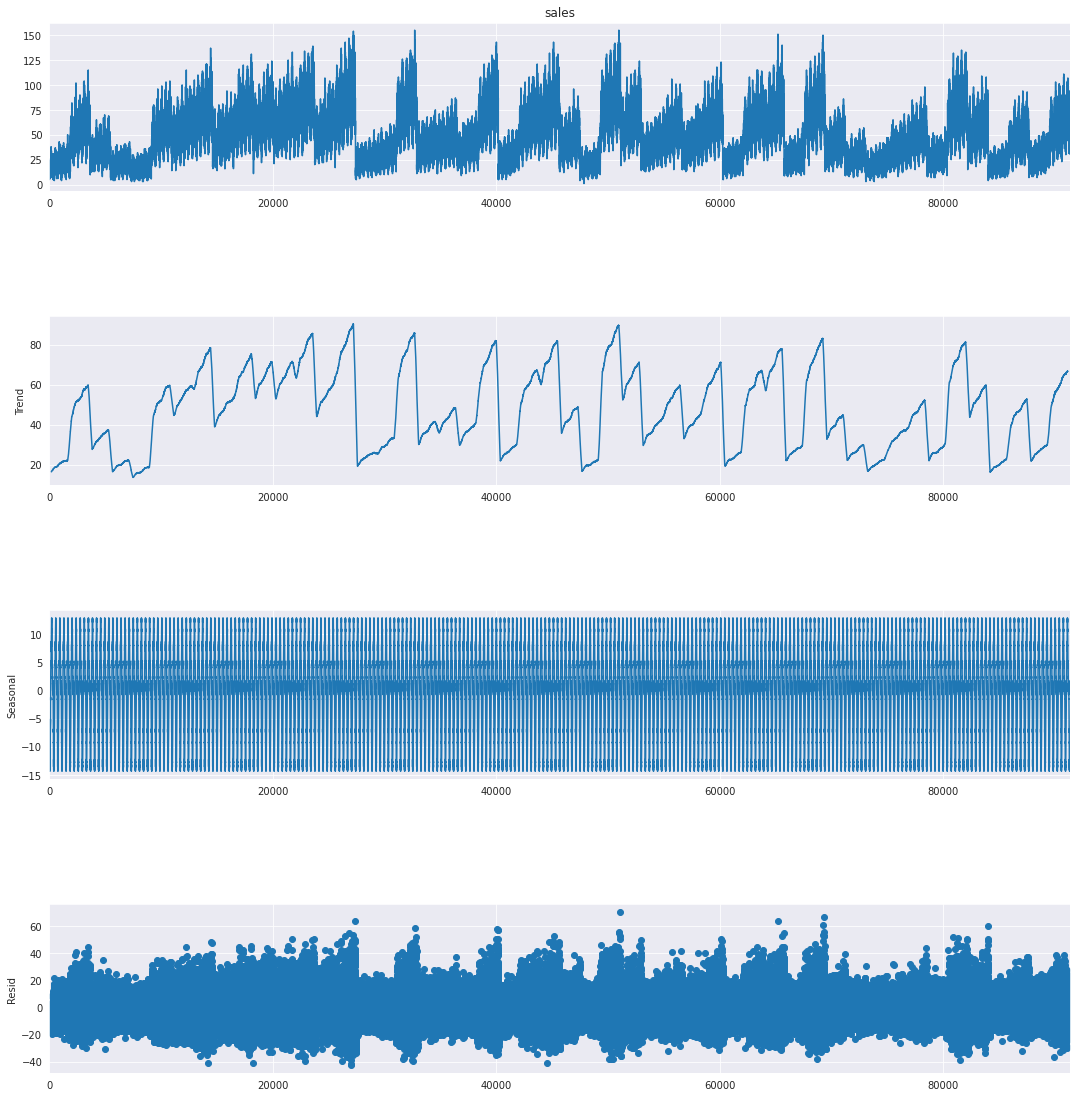

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_store1['sales'], model='additive', period=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 18)

### Looks like no tendecy and residuals are normally distributed

In [51]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

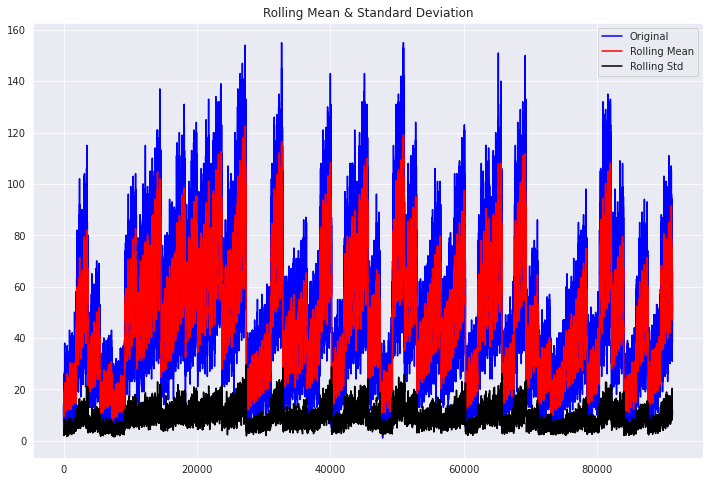

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -8.444610e+00
p-value                        1.726275e-13
#Lags Used                     2.000000e+01
Number of Observations Used    9.127900e+04
Critical Value (1%)           -3.430422e+00
Critical Value (5%)           -2.861572e+00
Critical Value (10%)          -2.566787e+00
dtype: float64


In [52]:
test_stationarity(df_store1['sales'])

### Despite Dickey-Fuller Test shows that the series is stationary, we see that the mean is bouncing around, so I decided to apply diferenciation just to be sure.
Now we know that <font color=red>d = 1</font>.

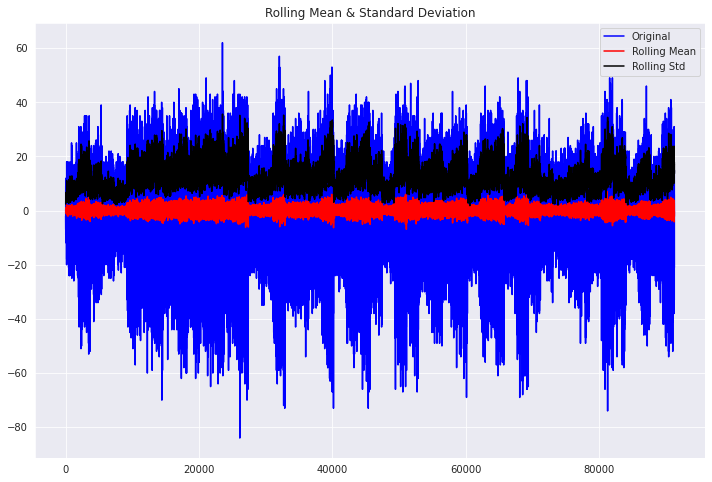

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -92.892681
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    91278.000000
Critical Value (1%)               -3.430422
Critical Value (5%)               -2.861572
Critical Value (10%)              -2.566787
dtype: float64


In [53]:
diff_lag1 = df_store1.sales - df_store1.sales.shift(1)
diff_lag1 = diff_lag1.dropna(inplace = False)
test_stationarity(diff_lag1)

## Time to discovery AR(p) and MA(q) using ACF and PACF

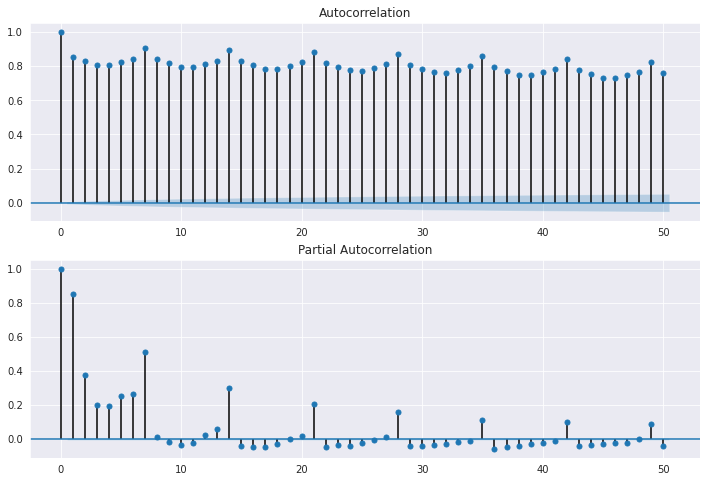

In [54]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_store1.sales, lags=50, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_store1.sales, lags=50, ax=ax2)# , lags=40

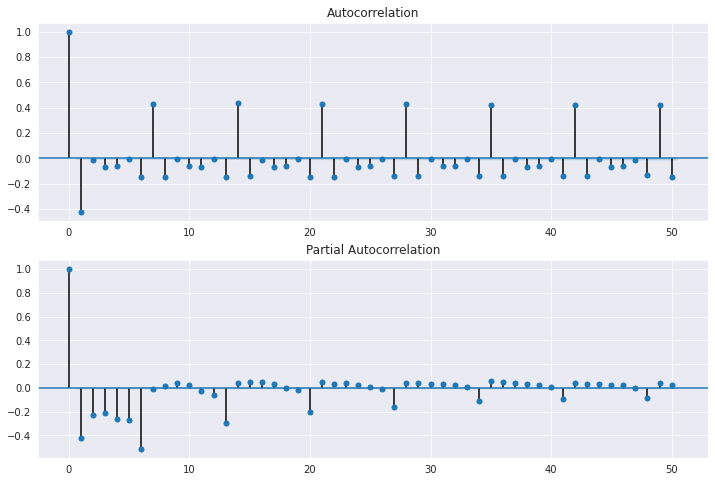

In [55]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_lag1, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_lag1, lags=50, ax=ax2)

## We can see that acf and pacf has a recurring pattern every 7 periods (weekly pattern). It should exists a seasonal trend on the data, so SARIMA should be considerer.

## MA Model (q)
### From acf test we get a pattern from legs 7, 14, 21, 28, and so on
## AR Model (p)
### From pacf test we get that the first 6 legs are significant, so AR(6)

### To test if AR model is enough, in the first situation I'll use MA(0), then investigate the residuals and lastly decide if should I use MA or not.

In [56]:
df_store1.head(10)

,date,item,sales,year,month,wk_num,wk_day_numb
0,2013-01-01,1,13.0,2013,1,1,1
1,2013-01-02,1,11.0,2013,1,1,2
2,2013-01-03,1,14.0,2013,1,1,3
3,2013-01-04,1,13.0,2013,1,1,4
4,2013-01-05,1,10.0,2013,1,1,5
5,2013-01-06,1,12.0,2013,1,1,6
6,2013-01-07,1,10.0,2013,1,2,0
7,2013-01-08,1,9.0,2013,1,2,1
8,2013-01-09,1,12.0,2013,1,2,2
9,2013-01-10,1,9.0,2013,1,2,3


In [57]:
arima6 = sm.tsa.ARIMA(df_store1.sales, (6,1,0)).fit(disp=False)
print(arima6.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                91299
Model:                 ARIMA(6, 1, 0)   Log Likelihood             -330440.993
Method:                       css-mle   S.D. of innovations              9.028
Date:                Sun, 20 Sep 2020   AIC                         660897.985
Time:                        15:29:53   BIC                         660973.360
Sample:                             1   HQIC                        660920.954
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.006      0.069      0.945      -0.011       0.012
ar.L1.D.sales    -0.8274      0.003   -291.315      0.000      -0.833      -0.822
ar.L2.D.sales    -0.7393      0.003   -2

<b>Analyze the result</b>

To see how our first model perform, we can plot the residual distribution, see if it's normal distributed, the ACF and PACF graphics. For a good model, we want to see the residual is normally distributed, and ACF, PACF has not significant terms.

NormaltestResult(statistic=1919.6961338273602, pvalue=0.0)


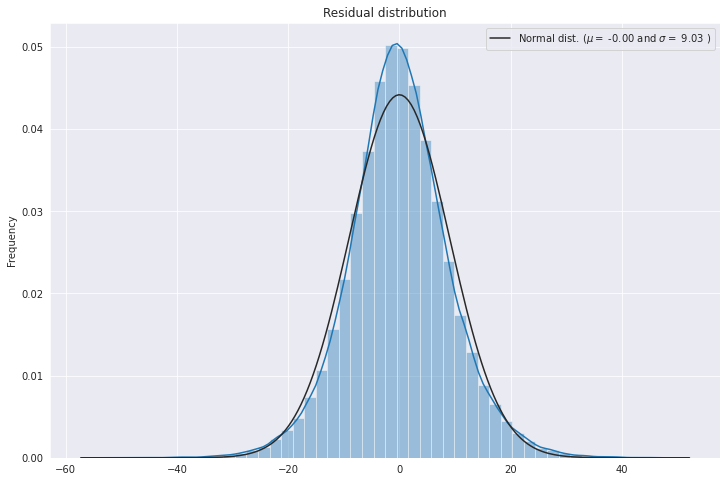

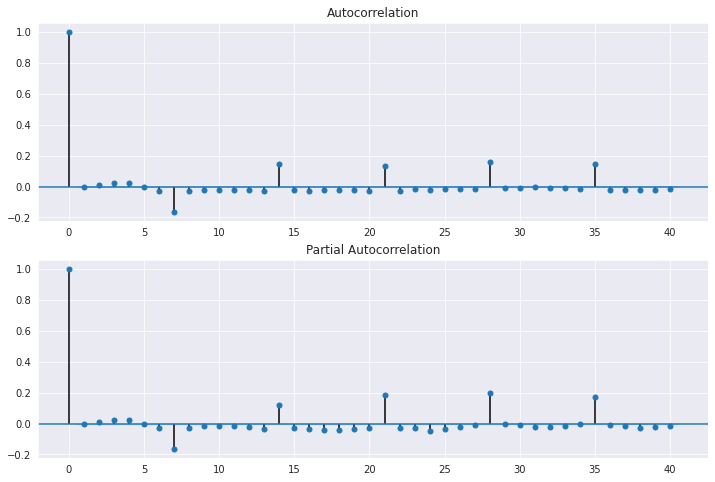

In [58]:
from scipy import stats
from scipy.stats import normaltest

resid = arima6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. 
# the p-value is very small, meaning the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima6.resid, lags=40, ax=ax2)

### The graph looks like a normal distribution, but it failed the test (p_value = 0.0). 
### Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality.

In [59]:
sarima6 = sm.tsa.statespace.SARIMAX(df_store1.sales, trend='n', order=(6,1,0)).fit()
print(sarima6.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                91300
Model:               SARIMAX(6, 1, 0)   Log Likelihood             -330440.995
Date:                Sun, 20 Sep 2020   AIC                         660895.990
Time:                        15:30:40   BIC                         660961.943
Sample:                             0   HQIC                        660916.088
                              - 91300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8274      0.002   -350.602      0.000      -0.832      -0.823
ar.L2         -0.7393      0.003   -270.249      0.000      -0.745      -0.734
ar.L3         -0.7157      0.003   -252.448      0.0

NormaltestResult(statistic=1919.4025197310375, pvalue=0.0)


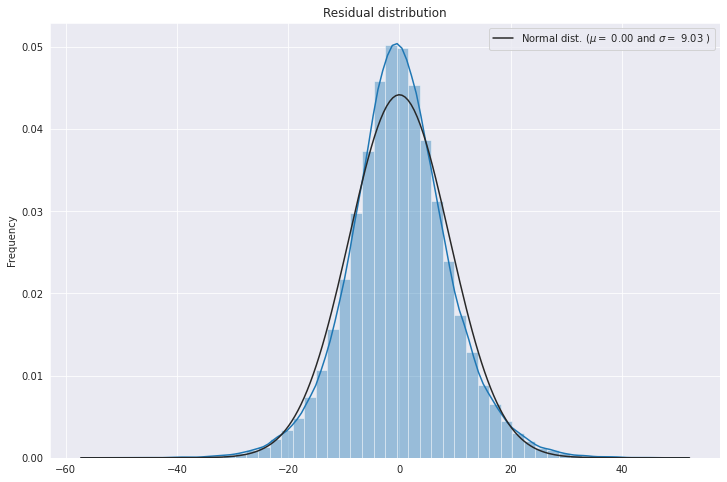

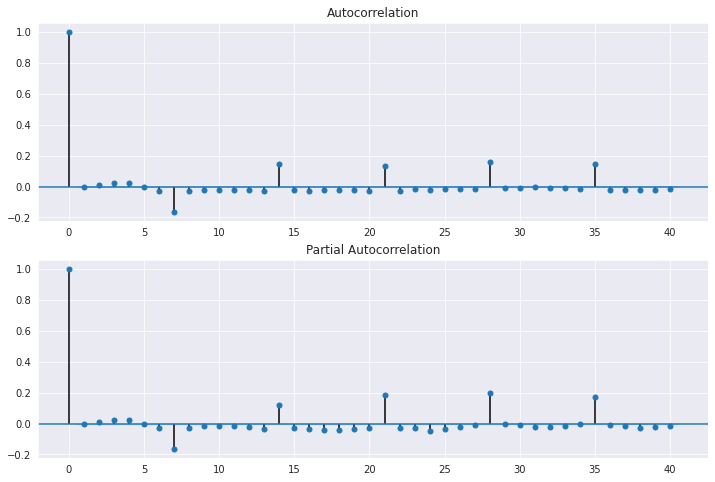

In [60]:
resid = sarima6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima6.resid, lags=40, ax=ax2)

### The model seems not to capture all the information from the data,
### however let's do some predictions

In [61]:
df_store1.shape

(91300, 7)

In [62]:
df_store1.head(15)

,date,item,sales,year,month,wk_num,wk_day_numb
0,2013-01-01,1,13.0,2013,1,1,1
1,2013-01-02,1,11.0,2013,1,1,2
2,2013-01-03,1,14.0,2013,1,1,3
3,2013-01-04,1,13.0,2013,1,1,4
4,2013-01-05,1,10.0,2013,1,1,5
5,2013-01-06,1,12.0,2013,1,1,6
6,2013-01-07,1,10.0,2013,1,2,0
7,2013-01-08,1,9.0,2013,1,2,1
8,2013-01-09,1,12.0,2013,1,2,2
9,2013-01-10,1,9.0,2013,1,2,3


In [63]:
df_store1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91300 entries, 0 to 91299
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         91300 non-null  datetime64[ns]
 1   item         91300 non-null  int64         
 2   sales        91300 non-null  float64       
 3   year         91300 non-null  int64         
 4   month        91300 non-null  int64         
 5   wk_num       91300 non-null  int64         
 6   wk_day_numb  91300 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 4.9 MB


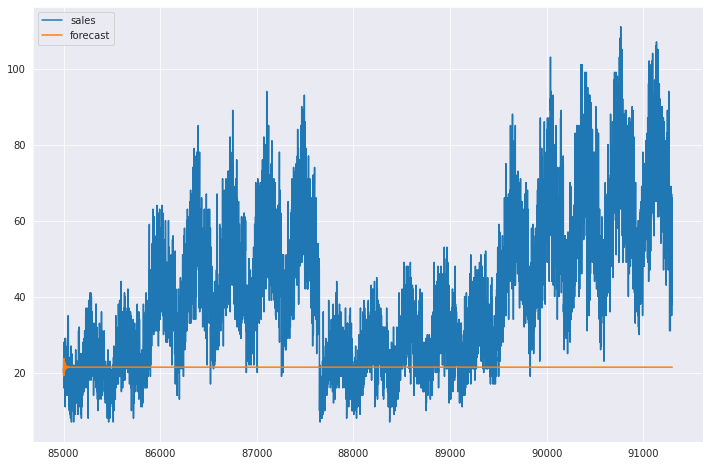

In [64]:
start_index = 85000
end_index = 91300
df_store1['forecast'] = sarima6.predict(start = start_index, end= end_index, dynamic= True)
df_store1[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [65]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [66]:
smape_kun(df_store1[90300:91299]['sales'],df_store1[90300:91299]['forecast'])

MAPE: 64.91 % 
SMAPE: 97.51 %


### Backup the data before forecasting

In [1]:
df_store1.to_csv (r'df_store1.csv', index = False, header=True)

NameError: name 'df_store1' is not defined

### Read the data from the backup

In [2]:
df_store1 = pd.read_csv('df_store1.csv', sep=',', engine='python')

NameError: name 'pd' is not defined

In [259]:
df_store1.head()

,date,item,sales,year,month,wk_num,wk_day_numb,forecast
0,2013-01-01,1,13.0,2013,1,1,1,NaN
1,2013-01-02,1,11.0,2013,1,1,2,NaN
2,2013-01-03,1,14.0,2013,1,1,3,NaN
3,2013-01-04,1,13.0,2013,1,1,4,NaN
4,2013-01-05,1,10.0,2013,1,1,5,NaN
